# Death Cox regression

Useful links:
- https://www.nature.com/articles/s41586-020-2521-4.pdf
- https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [2]:
from lifelines import CoxPHFitter

In [3]:
record_path = "./records/test_record_1/"

## Import data

In [4]:
people_df = pd.read_csv(record_path + "/people.csv")

In [5]:
people_df.set_index('id', inplace=True)

In [6]:
deaths_df = pd.read_csv(record_path + "/deaths.csv")

In [7]:
deaths_df = deaths_df.rename(columns={"Unnamed: 0": "id"})

In [8]:
deaths_df.set_index('id', inplace=True)

In [9]:
remove_care_home = False

## Process data

In [10]:
study_duration = (datetime(2020, 5, 16, 0, 0) - datetime(2020, 2, 1, 0, 0)).days

In [11]:
people_df = people_df.sort_index()

In [12]:
people_df_died = list(np.zeros(len(people_df)))
people_df_days_dead = list(np.ones(len(people_df)) * study_duration)
for idx, row in tqdm(deaths_df.iterrows(), total = len(deaths_df)):
    days_dead = (datetime.strptime(row["timestamp"], "%Y-%m-%d") - datetime(2020, 2, 1, 0, 0)).days
    if days_dead < study_duration:
        people_df_died[idx] = 1
        people_df_days_dead[idx] = days_dead

100%|██████████| 56587/56587 [00:04<00:00, 11959.65it/s]


In [13]:
people_df["died"] = list(np.array(people_df_died).astype(int))
people_df["days"] = list(np.array(people_df_days_dead).astype(int))

In [14]:
if remove_care_home:
    people_df = people_df[people_df["residence_type"] == "household"]

In [15]:
people_df.loc[people_df["sex"] == "f", "sex"] = 0
people_df.loc[people_df["sex"] == "m", "sex"] = 1

In [16]:
people_df.loc[people_df["ethnicity"] == "A", "ethnicity"] = 0
people_df.loc[people_df["ethnicity"] == "B", "ethnicity"] = 1
people_df.loc[people_df["ethnicity"] == "C", "ethnicity"] = 2
people_df.loc[people_df["ethnicity"] == "D", "ethnicity"] = 3
people_df.loc[people_df["ethnicity"] == "E", "ethnicity"] = 4

In [17]:
people_df.head()

,age,socioeconomic_index,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,died,days
id,,,,,,,,,,,
0,0,9,0,37,0,0,0,None,household,0,105
1,0,9,0,34,0,0,0,None,household,0,105
2,1,9,241,38,0,0,4,school,household,0,105
3,1,9,241,30,0,1,0,school,household,0,105
4,1,9,241,37,0,0,1,school,household,0,105


In [18]:
age_deaths_opensafely = {
    "18-39": 0.,
    "40-49": 0.,
    "50-59": 0.02,
    "60-69": 0.05,
    "70-79": 0.14,
    "80-100": 0.57,
}

In [19]:
died = np.array(people_df["died"])
age = np.array(people_df["age"])

In [20]:
died_age = died*age

In [21]:
age_bins = [
    [18,39],
    [40,49],
    [50,59],
    [60,69],
    [70,79],
    [80,100],
]

In [25]:
age_died = []
age_nos = []
age_died_nos = []
for age_bin in age_bins:
    age_no = np.where(np.logical_and(age>=age_bin[0], age<=age_bin[1]))[0]
    age_nos.append(len(age_no))
    died_age_no = np.where(np.logical_and(died_age>=age_bin[0], died_age<=age_bin[1]))[0]
    age_died_nos.append(len(died_age_no))
    age_died.append(len(died_age_no)*100./len(age_no))

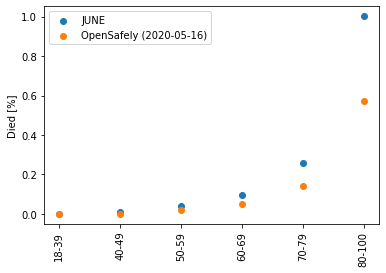

In [23]:
plt.scatter(np.arange(len(age_deaths_opensafely)), age_died, label = "JUNE")

plt.scatter(np.arange(len(age_deaths_opensafely)),
            [died for eth, died in age_deaths_opensafely.items()],
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(ticks = np.arange(len(age_deaths_opensafely)), rotation='vertical', labels=[eth for eth, died in age_deaths_opensafely.items()])
plt.legend()
plt.ylabel("Died [%]")
plt.show()

## Ethnicity analysis

### Global analysis

In [45]:
ethnicity_june = ["White", "Mixed", "Asian", "Black", "Other"]

In [46]:
total_ethnicity = np.array(people_df.groupby(["ethnicity"]).size())

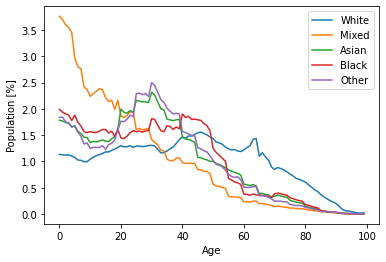

In [47]:
ax0 = (people_df[people_df["ethnicity"] == 0].groupby(["age"]).size()*100/total_ethnicity[0]).plot(
    label = ethnicity_june[0]
)
ax1 = (people_df[people_df["ethnicity"] == 1].groupby(["age"]).size()*100/total_ethnicity[1]).plot(
    label = ethnicity_june[1]
)
ax2 = (people_df[people_df["ethnicity"] == 2].groupby(["age"]).size()*100/total_ethnicity[2]).plot(
    label = ethnicity_june[2]
)
ax3 = (people_df[people_df["ethnicity"] == 3].groupby(["age"]).size()*100/total_ethnicity[3]).plot(
    label = ethnicity_june[3]
)
ax4 = (people_df[people_df["ethnicity"] == 4].groupby(["age"]).size()*100/total_ethnicity[4]).plot(
    label = ethnicity_june[4]
)

plt.legend()
plt.ylabel("Population [%]")
plt.xlabel("Age")
plt.show()

This is broadly in line with the cenus estimates: https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/demographics/age-groups/latest

In [48]:
ethnicity_deaths_opensafely = {
    "White": 0.07,
    "Mixed": 0.04,
    "South_Asian": 0.06, # note OS put Chinese in Other
    "Black": 0.07,
    "Other": 0.03
}

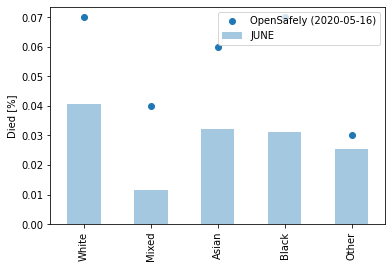

In [49]:
ax = (people_df[people_df["died"] == 1].groupby(["ethnicity"]).size()*100/total_ethnicity).plot.bar(
    rot = 0,
    label = "JUNE",
    alpha = 0.4,
)

plt.scatter(np.arange(len(ethnicity_deaths_opensafely)),
            [died for eth, died in ethnicity_deaths_opensafely.items()],
            marker = "o",
            label = "OpenSafely (2020-05-16)"
           )

plt.xlabel("")
plt.xticks(rotation='vertical')
ax.set_xticklabels(ethnicity_june)
plt.legend()
plt.ylabel("Died [%]")
plt.show()

### Cox's regression

In [13]:
people_cox_df = people_df[["age", "sex", "ethnicity", "died", "days"]]

In [45]:
people_cox_b = people_cox_df[people_cox_df["ethnicity"].isin([0,1])]
people_cox_c = people_cox_df[people_cox_df["ethnicity"].isin([0,2])]
people_cox_d = people_cox_df[people_cox_df["ethnicity"].isin([0,3])]
people_cox_e = people_cox_df[people_cox_df["ethnicity"].isin([0,4])]

In [46]:
people_cox_c["ethnicity"][people_cox_c["ethnicity"] == 2] = 1
people_cox_d["ethnicity"][people_cox_d["ethnicity"] == 3] = 1
people_cox_e["ethnicity"][people_cox_e["ethnicity"] == 4] = 1

/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/josephbullock/Documents/covidmodelling/JUNE-private/covidmodelling-private/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [47]:
cph = CoxPHFitter()

In [48]:
cph.fit(people_cox_b, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 0.11185, step_size = 0.9000, log_lik = -969853.19890, newton_decrement = 347.42608, seconds_since_start = 162.7
Iteration 2: norm_delta = 0.06779, step_size = 0.9000, log_lik = -969459.89567, newton_decrement = 68.41191, seconds_since_start = 320.9
Iteration 3: norm_delta = 0.02473, step_size = 0.9000, log_lik = -969385.82494, newton_decrement = 6.23763, seconds_since_start = 473.1
Iteration 4: norm_delta = 0.00211, step_size = 1.0000, log_lik = -969379.27987, newton_decrement = 0.03879, seconds_since_start = 625.4
Iteration 5: norm_delta = 0.00001, step_size = 1.0000, log_lik = -969379.24092, newton_decrement = 0.00000, seconds_since_start = 782.9
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -969379.24091, newton_decrement = 0.00000, seconds_since_start = 941.1
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.64639e+07 total observations, 4.6409e+07 right-censored observations>

In [49]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4.64639e+07 total observations, 4.6409e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.64639e+07
number of events observed = 54938
   partial log-likelihood = -969379.24
         time fit was run = 2021-07-28 15:31:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sex        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
ethnicity  -1.19       0.30       0.05            -1.29            -1.10                 0.28                 0.33

               z      p   -log2(p)
covariate                         
age         1.01   0.31       1.67
sex        -0.89   0.37       1.42
ethnicity -24.68 <0.005     444.30
---
Concordance = 0.51
Partial AIC = 1938764.48
log-likelihood ratio test = 947.92 on 3 df
-log2(p) of ll-ratio test = 679.16

In [50]:
cph = CoxPHFitter()

In [51]:
cph.fit(people_cox_c, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 0.23718, step_size = 0.9000, log_lik = -983208.28788, newton_decrement = 1567.73186, seconds_since_start = 163.2
Iteration 2: norm_delta = 0.16082, step_size = 0.9000, log_lik = -981417.19994, newton_decrement = 364.15263, seconds_since_start = 327.9
Iteration 3: norm_delta = 0.07535, step_size = 0.9000, log_lik = -981014.29256, newton_decrement = 48.99584, seconds_since_start = 494.4
Iteration 4: norm_delta = 0.01166, step_size = 1.0000, log_lik = -980961.32064, newton_decrement = 0.90471, seconds_since_start = 662.5
Iteration 5: norm_delta = 0.00024, step_size = 1.0000, log_lik = -980960.40383, newton_decrement = 0.00038, seconds_since_start = 825.9
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -980960.40346, newton_decrement = 0.00000, seconds_since_start = 990.7
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 4.94122e+07 total observations, 4.93567e+07 right-censored observations>

In [52]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4.94122e+07 total observations, 4.93567e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.94122e+07
number of events observed = 55501
   partial log-likelihood = -980960.40
         time fit was run = 2021-07-28 15:51:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sex        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
ethnicity  -1.61       0.20       0.03            -1.67            -1.54                 0.19                 0.21

               z      p   -log2(p)
covariate                         
age         0.80   0.42       1.24
sex        -0.62   0.53       0.90
ethnicity -50.23 <0.005        inf
---
Concordance = 0.53
Partial AIC = 1961926.81
log-likelihood ratio test = 4495.77 on 3 df
-log2(p) of ll-ratio test = inf

In [53]:
cph = CoxPHFitter()

In [54]:
cph.fit(people_cox_d, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 0.17429, step_size = 0.9000, log_lik = -968075.02045, newton_decrement = 835.24485, seconds_since_start = 159.0
Iteration 2: norm_delta = 0.13860, step_size = 0.9000, log_lik = -967105.60651, newton_decrement = 244.93105, seconds_since_start = 320.4
Iteration 3: norm_delta = 0.08571, step_size = 0.9000, log_lik = -966827.60284, newton_decrement = 50.06093, seconds_since_start = 480.8
Iteration 4: norm_delta = 0.02503, step_size = 1.0000, log_lik = -966771.01689, newton_decrement = 2.76246, seconds_since_start = 641.3
Iteration 5: norm_delta = 0.00174, step_size = 1.0000, log_lik = -966768.14065, newton_decrement = 0.01173, seconds_since_start = 800.5
Iteration 6: norm_delta = 0.00001, step_size = 1.0000, log_lik = -966768.12889, newton_decrement = 0.00000, seconds_since_start = 959.3
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, log_lik = -966768.12888, newton_decrement = 0.00000, seconds_since_start = 1119.4
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 4.71158e+07 total observations, 4.7061e+07 right-censored observations>

In [55]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4.71158e+07 total observations, 4.7061e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.71158e+07
number of events observed = 54794
   partial log-likelihood = -966768.13
         time fit was run = 2021-07-28 16:12:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sex        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
ethnicity  -2.03       0.13       0.06            -2.15            -1.92                 0.12                 0.15

               z      p   -log2(p)
covariate                         
age         0.70   0.48       1.05
sex        -0.77   0.44       1.19
ethnicity -34.55 <0.005     866.31
---
Concordance = 0.52
Partial AIC = 1933542.26
log-likelihood ratio test = 2613.78 on 3 df
-log2(p) of ll-ratio test = inf

In [56]:
cph = CoxPHFitter()

In [57]:
cph.fit(people_cox_e, duration_col="days", event_col="died", show_progress=True)

Iteration 1: norm_delta = 0.04959, step_size = 0.9000, log_lik = -967760.91870, newton_decrement = 67.90657, seconds_since_start = 152.7
Iteration 2: norm_delta = 0.01917, step_size = 0.9000, log_lik = -967687.06741, newton_decrement = 6.75409, seconds_since_start = 306.0
Iteration 3: norm_delta = 0.00374, step_size = 0.9000, log_lik = -967680.10657, newton_decrement = 0.21988, seconds_since_start = 458.9
Iteration 4: norm_delta = 0.00007, step_size = 1.0000, log_lik = -967679.88422, newton_decrement = 0.00006, seconds_since_start = 611.6
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -967679.88416, newton_decrement = 0.00000, seconds_since_start = 769.4
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 4.58181e+07 total observations, 4.57633e+07 right-censored observations>

In [58]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4.58181e+07 total observations, 4.57633e+07 right-censored observations>
             duration col = 'days'
                event col = 'died'
      baseline estimation = breslow
   number of observations = 4.58181e+07
number of events observed = 54863
   partial log-likelihood = -967679.88
         time fit was run = 2021-07-28 16:34:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sex        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
ethnicity  -0.60       0.55       0.05            -0.71            -0.50                 0.49                 0.61

               z      p   -log2(p)
covariate                         
age         0.64   0.52       0.94
sex        -0.81   0.42       1.25
ethnicity -11.40 <0.005      97.54
---
Concordance = 0.50
Partial AIC = 1935365.77
log-likelihood ratio test = 162.07 on 3 df
-log2(p) of ll-ratio test = 113.55

In [ ]:
ethnicity_opensafely = {
    "White": [1.,1.,1.]
    "Mixed": [1.11,1.43,1.84]
    "South_Asian": [1.32,1.45,1.58] # note the definition is slightly different
    "Black": [1.29,1.48,1.69]
    "Other": [1.1,1.33,1.61]
}

## Socioeconomic analysis

In [ ]:
deprivation_opensafely = {
    '5': [1.,1.,1.], # least deprived
    '4': [1.05,1.12,1.19],
    '3': [1.15,1.22,1.3],
    '2': [1.42,1.51,1.61],
    '1': [1.68,1.79,1.91] # most deprived
}